In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
import random
import seaborn as sns
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=14)
font2 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=12)
font3 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=10)
font4 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=7)
sns.set_style('whitegrid')
sns.set_palette("muted")
random.seed(20241120)
np.random.seed(20241120)
torch.manual_seed(3407) # Torch.manual_seed(3407) is all you need. Paper: http://arxiv.org/abs/2109.08203
# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [ ]:
# 专用于已有文件的一个临时封装函数
def load_data(data_path='E:\\科创优才\\实验数据\\天然气锅炉数据1.xlsx', sheet_name='稳定运行数据段',
                input_var_names=[
                    "主蒸汽流量计算值",
                    "锅炉天然气进气流量",
                    "锅炉天然气进气温度",
                    "锅炉天然气进气压力",
                    '鼓风机出口温度',
                    "鼓风机出口压力",
                    "鼓风机变频器输出反馈",
                    "鼓风机变频器电流反馈",
                    "冷凝器出口烟气调节阀反馈",
                    "SWY大气压",
                    "SWY天气温度",
                    "SWY空气湿度",
                    'SWY湿球温度',
                    "主蒸汽温度(蒸汽集箱出口温度）",
                    "主蒸汽压力(蒸汽集箱出口压力）",
                ],
                output_var_names=[
                    #"烟气含氧量（CEMS）",
                    #NO浓度",
                    #"NO2浓度", # 主要预测NO，因为NO2的准确性有待考量
                    "NOX浓度",
                    #"烟气湿度（CEMS）",
                    #"烟气压力（CEMS）",
                    #"烟气温度（CEMS）",
                    #"一氧化碳",
                    #"炉膛出口烟气压力",

                    #暂时不考虑以下输出变量
                    #"分汽缸温度",
                    #"分汽缸压力",
                    #"分汽缸出口至DN400蒸汽温度",
                    #"过热器集箱出口蒸汽温度",
                    #"冷凝器出口烟气流量",
                    #"冷凝器出口烟气温度",
                ]):

    df_whole=pd.read_excel(data_path, sheet_name=sheet_name)
    units=df_whole.iloc[0].tolist()
    df=df_whole.iloc[2:].reset_index(drop=True)

    # 重命名所有列名，缩短名称长度，方便使用
    df.columns=[
        '开始时间',
        '主蒸汽流量计算值',
        '烟气含氧量（CEMS）',
        '颗粒浓度',
        '二氧化硫',
        'NO浓度',
        'NO2浓度',
        'NOX标干浓度',
        'NOX浓度',
        '烟气湿度（CEMS）',
        '烟气压力（CEMS）',
        '烟气温度（CEMS）',
        '一氧化碳',
        '锅炉天然气进气流量',
        '锅炉天然气进气温度',
        '锅炉天然气进气压力',
        '鼓风机出口温度',
        '鼓风机出口压力',
        '鼓风机变频器输出反馈',
        '鼓风机变频器电流反馈',
        '再循环烟气调节阀反馈',
        '冷凝器出口烟气调节阀反馈',
        '炉膛出口烟气温度（B分度）',
        '炉膛出口烟气压力',
        'SWY大气压',
        'SWY天气温度',
        'SWY空气湿度',
        'SWY湿球温度',
        '主蒸汽温度（蒸汽集箱出口温度）',
        '主蒸汽压力（蒸汽集箱出口压力）',
        '分汽缸温度',
        '分汽缸压力',
        '分汽缸出口至DN400蒸汽温度',
        '过热器集箱出口蒸汽温度',
        '天然气累计流量',
        '冷凝器烟气流量（累计值）',
        '冷凝器出口烟气流量',
        '冷凝器出口烟气温度'
    ]

    # 将可能用到的变量名和单位存入字典
    var_dict={
        "主蒸汽流量计算值": "t/h",
        "烟气含氧量（CEMS）": "%",
        "NO浓度": "mg/Nm3",
        "NO2浓度": "mg/Nm3",
        "NOX浓度": "mg/Nm3",
        "烟气湿度（CEMS）": "%",
        "烟气压力（CEMS）": "Pa",
        "烟气温度（CEMS）": "℃",
        "一氧化碳": "mg/Nm3",
        "锅炉天然气进气流量": "m3/h",
        "锅炉天然气进气温度": "℃",
        "锅炉天然气进气压力": "kPa",
        '鼓风机出口温度': "℃",
        "鼓风机出口压力": "kPa",
        "鼓风机变频器输出反馈": "Hz",
        "鼓风机变频器电流反馈": "A",
        "冷凝器出口烟气调节阀反馈": "%",
        "炉膛出口烟气压力": "Pa",
        "SWY大气压": "kPa",
        "SWY天气温度": "℃",
        "SWY空气湿度": "%",
        'SWY湿球温度': "℃",
        "主蒸汽温度（蒸汽集箱出口温度）": "℃",
        "主蒸汽压力（蒸汽集箱出口压力）": "MPa",
        "分汽缸温度": "℃",
        "分汽缸压力": "MPa",
        '分汽缸出口至DN400蒸汽温度': "℃",
        '过热器集箱出口蒸汽温度': "℃",
        "冷凝器出口烟气流量": "Nm3/h",
        "冷凝器出口烟气温度": "℃",
    }
    var_names=list(var_dict.keys())

    input_var_dict={name:var_dict[name] for name in input_var_names}
    output_var_dict={name:var_dict[name] for name in output_var_names}

    var_units=list(var_dict.values())
    input_var_units=list(input_var_dict.values())
    output_var_units=list(output_var_dict.values())

    input_var_indices=[var_names.index(name) for name in input_var_names]
    output_var_indices=[var_names.index(name) for name in output_var_names]

    data_np=df[var_names].to_numpy(dtype=float)
    
    DATA=[
        data_np[:100,:],
        data_np[100:200,:],
        data_np[200:300,:],
        data_np[300:400,:],
        data_np[400:500,:],
        data_np[500:600,:],
        data_np[600:700,:],
        data_np[700:800,:],
        data_np[800:900,:],
        data_np[900:1000,:],
        data_np[1000:,:],
        ]
    '''
    DATA=[
        data_np[:200,:],
        data_np[200:400,:],
        data_np[400:600,:],
        data_np[600:800,:],
        data_np[800:1000,:],
        #data_np[1000:,:],
        ]'''
    print("data_np.shape:", data_np.shape)

    return DATA, \
            (var_names, var_units), \
            (input_var_units, output_var_units), \
            (input_var_indices, output_var_indices)


In [178]:
df_whole=pd.read_excel("E:\\科创优才\\实验数据\\天然气锅炉数据1.xlsx", sheet_name="1-2月份数据")
units=df_whole.iloc[0].tolist()
df=df_whole.iloc[2:].reset_index(drop=True) # 只截取数据部分

# 重命名所有列名，缩短名称长度，方便使用
df.columns=[
    '开始时间',
    '主蒸汽流量计算值',
    '烟气含氧量（CEMS）',
    '颗粒浓度',
    '二氧化硫',
    'NO浓度',
    'NO2浓度',
    'NOX标干浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '再循环烟气调节阀反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '天然气累计流量',
    '冷凝器烟气流量（累计值）',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]

# 将可能用到的变量名和单位存入字典
var_dict={
    "主蒸汽流量计算值": "t/h",
    "烟气含氧量（CEMS）": "mg/Nm3",
    "NO浓度": "mg/Nm3",
    "NO2浓度": "mg/Nm3",
    "NOX浓度": "mg/Nm3",
    "烟气湿度（CEMS）": "%",
    "烟气压力（CEMS）": "Pa",
    "烟气温度（CEMS）": "℃",
    "一氧化碳": "mg/Nm3",
    "锅炉天然气进气流量": "m3/h",
    "锅炉天然气进气温度": "℃",
    "锅炉天然气进气压力": "kPa",
    '鼓风机出口温度': "℃",
    "鼓风机出口压力": "kPa",
    "鼓风机变频器输出反馈": "Hz",
    "鼓风机变频器电流反馈": "A",
    "冷凝器出口烟气调节阀反馈": "%",
    "炉膛出口烟气压力": "Pa",
    "SWY大气压": "kPa",
    "SWY天气温度": "℃",
    "SWY空气湿度": "%",
    'SWY湿球温度': "℃",
    '主蒸汽温度(蒸汽集箱出口温度）': "℃",
    "主蒸汽压力(蒸汽集箱出口压力）": "MPa",
    "分汽缸温度": "℃",
    "分汽缸压力": "MPa",
    '分汽缸出口至DN400蒸汽温度': "℃",
    '过热器集箱出口蒸汽温度': "℃",
    "冷凝器出口烟气流量": "Nm3/h",
    "冷凝器出口烟气温度": "℃",
}
var_names=list(var_dict.keys())

# 定义输入变量
input_var_names=[
    "主蒸汽流量计算值",
    "锅炉天然气进气流量",
    "锅炉天然气进气温度",
    "锅炉天然气进气压力",
    '鼓风机出口温度',
    "鼓风机出口压力",
    "鼓风机变频器输出反馈",
    "鼓风机变频器电流反馈",
    "冷凝器出口烟气调节阀反馈",
    "SWY大气压",
    "SWY天气温度",
    "SWY空气湿度",
    'SWY湿球温度',
    "主蒸汽温度(蒸汽集箱出口温度）",
    "主蒸汽压力(蒸汽集箱出口压力）",
]

# 定义输出变量
output_var_names=[
    "烟气含氧量（CEMS）",
    #NO浓度",
    #"NO2浓度", # 主要预测NO，因为NO2的准确性有待考量
    "NOX浓度",
    "烟气湿度（CEMS）",
    "烟气压力（CEMS）",
    "烟气温度（CEMS）",
    "一氧化碳",
    "炉膛出口烟气压力",

    #暂时不考虑以下输出变量
    #"分汽缸温度",
    #"分汽缸压力",
    #"分汽缸出口至DN400蒸汽温度",
    #"过热器集箱出口蒸汽温度",
    #"冷凝器出口烟气流量",
    #"冷凝器出口烟气温度",
]

input_var_dict={name:var_dict[name] for name in input_var_names}
output_var_dict={name:var_dict[name] for name in output_var_names}

var_units=list(var_dict.values())
input_var_units=list(input_var_dict.values())
output_var_units=list(output_var_dict.values())

input_var_indices=[var_names.index(name) for name in input_var_names]
output_var_indices=[var_names.index(name) for name in output_var_names]


data_np=df[var_names].to_numpy(dtype=float)

# 通过不同切片增加数据量





DATA=[
    data_np,
    data_np[:20,:],
    data_np[:50,:],
    data_np[:100,:],
    data_np[:800,:],
    data_np[100:850,:],
    data_np[200:900,:],
    data_np[300:950,:],
    data_np[400:1000,:],
    ]
print("data_np.shape:", data_np.shape)

data_np.shape: (17281, 30)


In [ ]:

def filter_segments(data, condition, min_length=15, min_gap=10): # Note: The implementation of this function is messy, no need to think too much about it, just use it as a black box.
    '''
    Filter segments of time series data and return a list of segments.

    :param data: numpy array of shape (n, p), where n is the number of timesteps, and p is the number of variables/channels/features.
    :param condition: boolean numpy array of shape (n, 1), indicating whether a sample (the data within a timestep) is an effective one.
    :param min_length: minimum length of a segment (in timesteps). If a segment is too short, it will be discarded.
    :param min_gap: minimum gap between two segments (in timesteps). If two segments are too close to each other, they will be merged into one.
    
    :return: a list of 2-d numpy arrays, where each array is a segment of the input data. A example shape is [(26,5), (144,5), ..., (97,5)].

    Example Usage:
    ```
    data=np.array([np.sin(0.05*np.pi*np.arange(500)+phase) for phase in np.linspace(0,np.pi,5)]).T\
        + np.random.normal(0,0.1,size=(500,5)) # data.shape = (500,5)
    condition=data[:,0]<0.5
    segments=filter_segments(data, condition, min_length=2, min_gap=3)
    for s in segments:
        print(s.shape)
    ```

    Note: The implementation of this function is messy, no need to think too much about it, just use it as a black box.
    '''
    def filter_indices(condition, min_length=15, min_gap=10):
        '''
        Filter the indices of segments of a time series data based on the condition array.

        The annotations of `condition`, `min_length`, and `min_gap` are the same as in the `filter_segments` function.

        :param condition: boolean numpy array of shape (n, 1), indicating whether a sample is an effective one.
        :param min_length: minimum length of a segment (in timesteps). If a segment is too short, it will be discarded.
        :param min_gap: minimum gap between two segments (in timesteps). If two segments are too close to each other, they will be merged into one.
        
        :return: a list of tuples, where each tuple represents the start and end timestep of a segment. A example tuple is (26, 144), which means the segment starts at timestep 26 and ends at timestep 144.
        
        In the annotation below within this function, we denote a segment as a tuple of (start_index, end_index), and the index of a segment is its position in indices (the list of segments).
        '''
        indices=[]
        state=False
        start_index=0
        end_index=0
        for i, symbol in enumerate(condition):
            if state==False and symbol==True:
                start_index=i
                state=True
            if state==True and symbol==False:
                end_index=i
                indices.append((start_index, end_index))
                state=False

        # Below: Remove segments that are too short (shorter than `min_length` timesteps)
        indices_filtered=[]
        for (start_index, end_index) in indices:
            if end_index - start_index >= min_length: # Only take segments that are at least `min_length` timesteps long
                indices_filtered.append((start_index, end_index))
        indices=indices_filtered

        # Below: Merge segments that are too close to each other (less than `min_gap`` timesteps)
        new_indices=[]
        list1=[] # Stores the indices of segments where the next segment is too close to the current segment (less than `min_gap`` timesteps)
        for i in range(len(indices)-1):
            if indices[i+1][0] - indices[i][1] < min_gap: # If the start timestep of the next segment is less than `min_gap`` timesteps from the end timestep of the c
                list1.append(i)
        i=0 # Index of the current segment
        while i<len(indices)-1:
            if indices[i+1][0] - indices[i][1] >= min_gap: # The normal case, where the next segment is far enough from the current segment
                new_indices.append((indices[i][0],indices[i][1]))
                i+=1
            elif indices[i+1][0] - indices[i][1] < min_gap: # If the next segment is too close to the current segment
                idx=list1.index(i) # Find the index of the current segment in the list1
                n=1 # The number of consecutive segments that are too close to the previous one
                while idx!=len(list1)-1 and list1[idx+n] == list1[idx]+n: # If indices[idx+n] is in list1, it means that the next segment is too close to
                    n=n+1
                new_indices.append((indices[i][0],indices[i+n][1]))
                i+=(n+1)
        return new_indices

    indices = filter_indices(condition, min_length, min_gap)
    return [data[start:end] for start, end in indices]


condition = data_np[:, 1] < 10
k=filter_segments(data_np, condition, min_length=15, min_gap=10)
for i in k:
    print(i.shape)



(19, 30)
(45, 30)
(113, 30)
(108, 30)
(95, 30)
(98, 30)
(111, 30)
(113, 30)
(118, 30)
(227, 30)
(106, 30)
(73, 30)
(48, 30)
(27, 30)
(15, 30)
(136, 30)
(110, 30)
(37, 30)
(114, 30)
(1124, 30)


In [194]:
np.sin(2*np.pi*np.arange(500)+0.1)

array([0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983342,
       0.09983342, 0.09983342, 0.09983342, 0.09983342, 0.09983

In [201]:
data=np.array([np.sin(0.05*np.pi*np.arange(500)+phase) for phase in np.linspace(0,np.pi,5)]).T\
    + np.random.normal(0,0.1,size=(500,5))
condition=data[:,0]<0.5
segments=filter_segments(data, condition, min_length=2, min_gap=3)
for s in segments:
    print(s.shape)


(3, 5)
(27, 5)
(26, 5)
(27, 5)
(25, 5)
(27, 5)
(26, 5)
(26, 5)
(27, 5)
(26, 5)
(27, 5)
(27, 5)


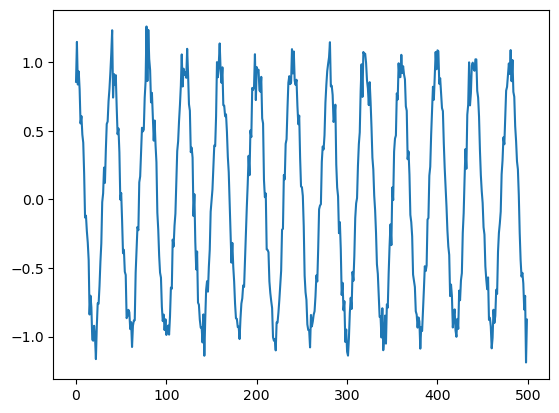

In [199]:
plt.plot(data[:,1])

In [3]:
from gas_data_prediction.data_reading import load_data

DATA, \
(var_names, var_units), \
(input_var_units, output_var_units), \
(input_var_indices, output_var_indices)=load_data(sheet_name='1-2月份数据')

data_np.shape: (17281, 30)
